# Plot Poster Figures

Ploting the figures of the Galaxy Cluster Conference Paper 2022

In [1]:
%cd ../

/Users/jesteves/Documents/GitHub/galaxyFormation


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('./scripts')
from file_loc import FileLocs
from compute_fractions import *
from utils import check_non_valid_number, gaussian_kde

In [3]:
import seaborn as sns
sns.set_context('poster', font_scale=0.7)
sns.set_style("darkgrid")


In [4]:
def save_figures(fig,fname,is_tight=False):
    if is_tight: fig.tight_layout()
    fig.savefig(fname,transparent=False,facecolor='w',dpi=100)

# Load Data

In [5]:
fl = FileLocs(dataset='sdss')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['VOLUME_LIM_MASK'].astype(bool)

gal = gal0[mask].copy()
cat = fl.load_catalogs('cluster/frac_vl')

Loading Catalog: ./data/catalogs/SDSS/groups_deCarvalho2017_R200m_galaxies_final_flag_johnnyheq_pp.csv
Loading Catalog: ./data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017_frac_vl.csv


## Setting Variables

In [6]:
gid = np.array(gal['Yang'])

zgal = np.array(gal['z'])
Mr   = np.array(gal['Mr'])

log_smass = np.array(gal['mass'])
smass = 10**log_smass
redshift = np.array(gal['redshift'])

rn = np.array(gal['Rm'])
vn = np.array(gal['vlosn'])
morph_type = np.array(gal['TType'])
ssfr = np.array(gal['ssfr'])

# sfr classification
sf   = np.array(gal['SF']).astype(int)
qf   = (1-sf).astype(int)

# morphological classification
sp   = np.where(gal['TType'] > 0, 1, 0).astype(int)
ell  = np.where(gal['TType'] <=0, 1, 0).astype(int)
s0   = check_non_valid_number(gal['Pbulge'])
s0[np.isnan(s0)] = 0.

# b/t definition
bt = np.array(gal['BT'])
bt2 = np.where(bt>=0.5,1.,bt)
bt2 = np.where(bt<0.5,0.,bt2)

# dynamical probabilities
Pi   = np.array(gal['p_infall'])
Po   = np.array(gal['p_orbital'])
Pn   = np.array(gal['p_interlopers'])
Pf = np.where(rn>2,Pn,0.)

m200 = np.array(gal['M200c'])

# mask
bt_mask = bt>=0.

# Sections

The folowing sections correspond to each block on the paper. Usually I'll have one figure per section. 

## Data - SDSS

### Figure 1

In [7]:
figure1 = 'poster/fig1_data_mr_evolution.png'

In [8]:
label_fsize = 22

label_z = r'z'
label_mr = r'M$_{r}$ [mag]'
label_smass = r'M$_{\star}$ [M$_{\odot}$]'
label_log_smass = r'Log(M$_{\star}$/M$_{\odot}$)'

label_sdss = 'SDSS DR7 MPA-JPU'

In [9]:
Mr_thrshold = -20.16

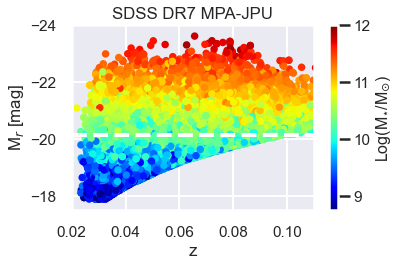

In [10]:
fig = plt.figure(figsize=(6,4))
plt.scatter(zgal,Mr,c=np.log10(smass),vmin=8.75,vmax=12.,s=30,cmap='jet')
# plt.plot(zbins2, ylow, ls='--',lw=4,color='w')
plt.axhline(Mr_thrshold,ls='--',lw=4,color='w')
plt.ylim(-18.5+1,-24.)
plt.xlim(0.02, 0.11)

plt.colorbar().set_label(label_log_smass,fontsize=16)
plt.xlabel(label_z)
plt.ylabel(label_mr)
plt.title(label_sdss)
save_figures(fig,figure1,is_tight=True)

## Dynamical Classification

In [11]:
figure2 = 'poster/fig2_dynamicalClass_phase_space.png'

Dynamical Classification Labels: ['Orbital', 'Infall', 'Interlopers', 'Field']
Color pallete


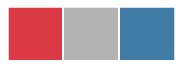

In [12]:
list_labels_dynamics = ['Orbital', 'Infall', 'Interlopers','Field']

colors_dynamics = sns.diverging_palette(10, 240, n=3)
colors_dynamics[1] = sns.color_palette("Set2")[7]
cmap_dynamics = sns.diverging_palette(10, 240, n=9, as_cmap=True)

print(f'Dynamical Classification Labels: {list_labels_dynamics}')
print('Color pallete')
sns.palplot(colors_dynamics)

In [13]:
tags = np.argmax(np.vstack([Po,Pi,Pn]).T,axis=1)
probs = np.max(np.vstack([Po,Pi,Pn]).T,axis=1)
probs.size

43722

In [14]:
label_rnorm = r'$\rm R/R_{200m}$'
label_vnorm = r'$\rm v_{los}/ v_{circ} $'

In [15]:
# f, axs = plt.subplots(1,1,figsize=(8,6))

def plot_phase_space(x,v,tags,probs,axs=None,scale=50,**kwargs):    
    prob_scale = scale*np.sqrt(probs)+0.
    p = axs.scatter(x,v,c=tags,cmap=cmap_dynamics,s=prob_scale,alpha=0.1)
    axs.set_xlabel(label_rnorm,fontsize=20)
    axs.set_ylabel(label_vnorm,fontsize=24)
    
def plot_histogram():
    binwidth = 0.1
    xymax = max(np.max(np.abs(rn)), np.max(np.abs(vn)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)

    ax_histx.tick_params(axis="x", labelbottom=False)
    _ = ax_histx.hist(rn, bins=bins, weights=Po,label=list_labels_dynamics[0],
                      color=colors_dynamics[0], histtype='stepfilled',
                      lw=6,alpha=0.5)

    _ = ax_histx.hist(rn, bins=bins, weights=Pn,label=list_labels_dynamics[2],
                      color=colors_dynamics[2], histtype='stepfilled',
                      lw=6,alpha=0.5)

    _ = ax_histx.hist(rn, bins=bins, weights=Pi,label=list_labels_dynamics[1],
                      color='lightgray', histtype='stepfilled',
                      lw=3,alpha=0.5,edgecolor='gray')

    ax_histx.legend(bbox_to_anchor=(0.1, 1.1, 0.8, .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., shadow=False)


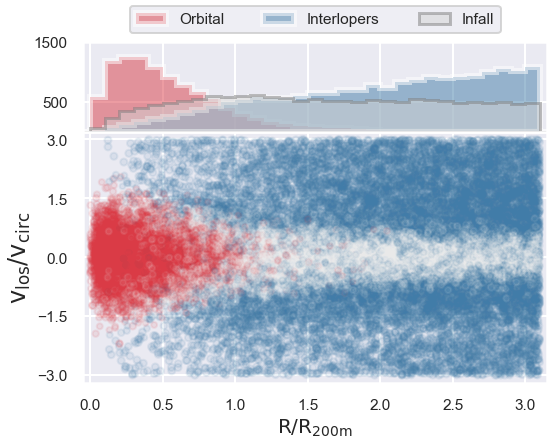

In [16]:
# start with a square Figure
fig = plt.figure(figsize=(8, 6.5))

# Add a gridspec with two rows and one columns and a ratio of 2.5 to 7 between
gs = fig.add_gridspec(2, 1,  height_ratios=(2.5, 7),
                      wspace=0.0, hspace=0.)

# defining sub-axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

plot_phase_space(rn,vn,tags,probs,axs=ax,scale=50,alpha=0.1)
plot_histogram()

ax.set_xlim(-0.05,3.15)
ax.set_ylim(-3.2,3.2)
ax_histx.set_xlim(-0.05,3.15)

ax.set_yticks(np.array([-3.,-1.5,0.,1.5,3.]))
ax_histx.set_yticks(np.array([500,1500]))
save_figures(fig,figure2,is_tight=True)

## Quenching Pannel

In [28]:
figure3 = 'poster/fig3_quenching_pannel_radii.png'
figureX = 'poster/figX_quenching_pannel_smass.png'
label1 = ['Cluster', 'Infall', 'Interlopers']
label2 = ['Orbital-Infall', 'Orbital-Interlopers', 'Infall-Interlopers', 'Infall-Field']
xlabels = {'cross_time':r't$_{cross}$ [Gyr]','smass':r'Log($M_\star/M_{\odot}$)','radii':r'R/R$_{200}$'}


In [53]:
sns.set_style("whitegrid")
sns.set_context("talk",font_scale=1.0)

In [54]:
key    = 'volumeLimited'
name   = 'quenching'
xlabel = 'radii'
save   = True

In [55]:
colors_dynamics2 = colors_dynamics.copy()
colors_dynamics2[1] = colors_dynamics[2]
colors_dynamics2[2] = colors_dynamics[1]

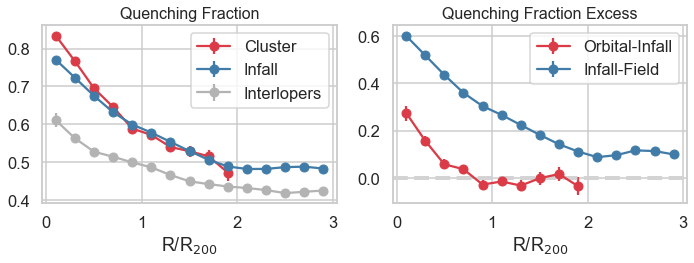

In [56]:
fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
x = np.loadtxt(fname).T

fig = plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
count = np.zeros_like(x[0])
for i in range(3):
    ii = 4*i + 1
    p = plt.errorbar(x[0][::2], x[ii][::2], yerr=np.vstack([x[ii+1][::2],x[ii+2][::2]]),
                     ls='-', label=label1[i], fmt='o', color=colors_dynamics2[i])

plt.legend()
plt.xlabel(xlabels[xlabel])
#plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
plt.title('%s Fraction'%name.capitalize(),fontsize=16)

plt.subplot(1, 2, 2)
jj=0
for i in np.array([0,3]):
    ii = (4*i + 1)+16
    x[ii] = np.where(x[ii]<-.75,np.nan,x[ii])
    p = plt.errorbar(x[0][::2], x[ii][::2], yerr=np.vstack([x[ii+1][::2],x[ii+2][::2]]),
                     label=label2[i], ls='-', fmt='o', color=colors_dynamics2[jj])
    jj += 1

plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel])
plt.legend()
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,figure3,is_tight=True)

In [57]:
xlabel = 'smass'

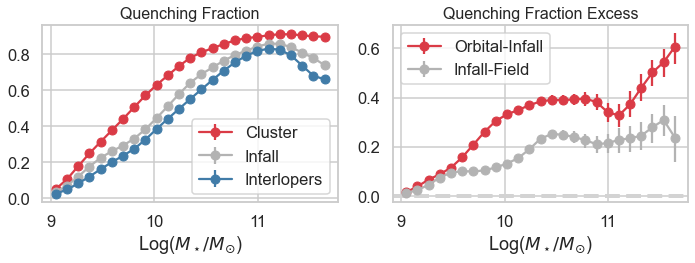

In [58]:
fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
x = np.loadtxt(fname).T

fig = plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
count = np.zeros_like(x[0])
for i in range(3):
    ii = 4*i + 1
    p = plt.errorbar(x[0][::2], x[ii][::2], yerr=np.vstack([x[ii+1][::2],x[ii+2][::2]]),
                     ls='-', label=label1[i], fmt='o', color=colors_dynamics[i])

plt.legend()
plt.xlabel(xlabels[xlabel])
#plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
plt.title('%s Fraction'%name.capitalize(),fontsize=16)

plt.subplot(1, 2, 2)
jj=0
for i in np.array([0,3]):
    ii = (4*i + 1)+16
    x[ii] = np.where(x[ii]<-.75,np.nan,x[ii])
    p = plt.errorbar(x[0][::2], x[ii][::2], yerr=np.vstack([x[ii+1][::2],x[ii+2][::2]]),
                     label=label2[i], ls='-', fmt='o', color=colors_dynamics[jj])
    jj += 1

plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel])
plt.legend()
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,figureX,is_tight=True)

## The Infall Region: Quenching

In [59]:
figure4 = 'poster/fig4_sSFRmass_pannel.png'

In [60]:
label_sfr = r'SFR [$ M_{\star} / yr$]'
label_ssfr = r'sSFR [yr$^{-1}$]'

In [61]:
def get_kde(xy,weights=None):
    pdf = gaussian_kde(xy, weights=weights)
    pdf.set_bandwidth(bw_method=pdf.factor / 1.)  # kde bandwidth
    zz2 = pdf((np.ravel(xx), np.ravel(yy)))
    zz2 = np.reshape(zz2, xx.shape)
    return zz2

def get_density(x1,x2,x3):
    f = get_kde(np.vstack([x1,x2]),weights=x3)
    return f.T

In [62]:
# grid
xmin, xmax = 9., 11.75
ymin, ymax = -13.25, -9.
x = np.linspace(xmin, xmax, 100)  # kde resolution
y = np.linspace(ymin, ymax, 100)  # kde resolution
xx, yy = np.meshgrid(x, y)

nz = ssfr>-20
pdf_o = get_density(log_smass[nz],ssfr[nz],Po[nz])
pdf_i = get_density(log_smass[nz],ssfr[nz],Pi[nz])
pdf_f = get_density(log_smass[nz],ssfr[nz],Pf[nz])

In [63]:
def sSFRmass(image,xth=0.0,ax=None,title=None,xlabel=label_log_smass):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

#     cfset = ax.contourf(xx, yy, f, cmap='jet')
    ax.imshow(np.rot90(image), cmap='jet', extent=[xmin, xmax, ymin, ymax], aspect=0.5)
    cset = ax.contour(xx, yy, image.T, 4, colors='gray')
    ax.clabel(cset, inline=1, fontsize=10, inline_spacing=0)
    ax.set_xlabel(xlabel)
    ax.axhline(-11.0,ls='--',lw=3,color='white')
    if title is not None:
        ax.set_title(title,fontsize=40)

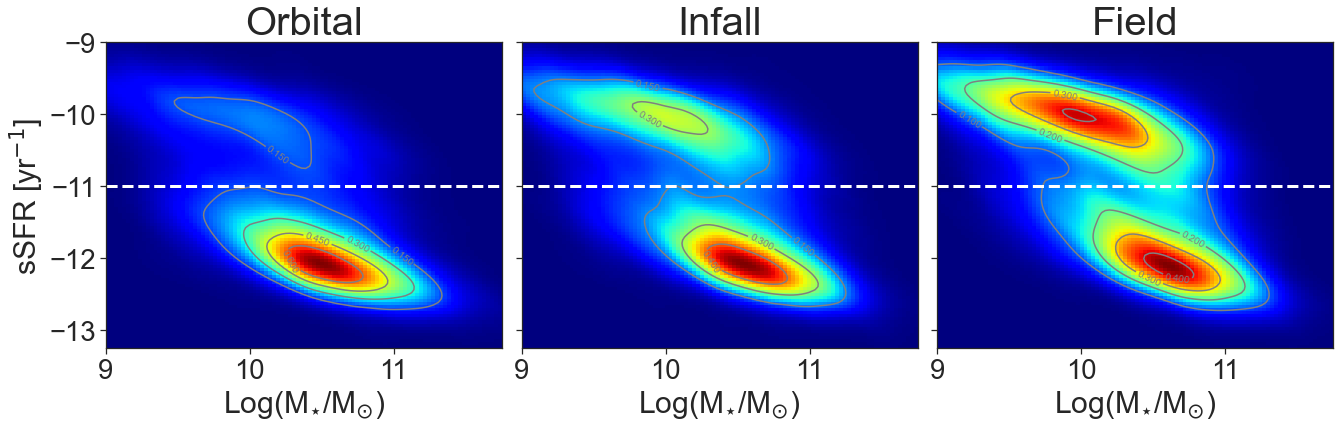

In [64]:
sns.set_style("ticks")
sns.set_context('notebook',font_scale=2.5)
fig, axis = plt.subplots(1, 3, figsize=(3*6+4,6.2),sharey='row')
fig.subplots_adjust(wspace=0.05,hspace=0.05)

sSFRmass(pdf_o,ax=axis[0],title=list_labels_dynamics[0])
sSFRmass(pdf_i,ax=axis[1],title=list_labels_dynamics[1])
sSFRmass(pdf_f,ax=axis[2],title=list_labels_dynamics[3])

axis[0].set_ylabel(label_ssfr)
save_figures(fig,figure4,is_tight=False)

## Morphology

In [79]:
figure5 = 'poster/fig5_quenching_distribution.png'
figure6 = 'poster/fig6_sSFRmass_spiral_pannel.png'

In [80]:
sns.set_style("whitegrid")
sns.set_context("talk",font_scale=1.0)

In [70]:
reds = sns.diverging_palette(10, 240, n=12)[:2]
reds[1] = sns.diverging_palette(10, 240, n=12)[4]
# reds = np.flip(reds)

blus = sns.diverging_palette(10, 240, n=12)[-2:]
blus[1] = sns.diverging_palette(10, 240, n=12)[-4]

In [71]:
def plot_enviroment3(cat1,mytpe1,mytpe2,title='SDSS',outname=None):
    y1,x1 = get_variables(cat1,mytpe1)
    y2,x2 = get_variables(cat1,mytpe2)
    
    y = np.hstack([y1,y2])
    x = np.hstack([x1,x2])
    
    labels = np.full((x.size),mytpe2)
    labels[:x1.size] = mytpe1
    
    res = pd.DataFrame({'fraction':y,'environment':x,'label':labels})
    
    plt.clf()
    g = sns.catplot(x='environment', y="fraction", kind="box", hue="label", 
                    data=res,estimator=np.median, palette=reds, legend=False)
    plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., shadow=False)
    plt.title(title,fontsize=18)
    if outname is not None:
        save_figures(plt,outname,is_tight=True)

def get_variables(cat0,mytpe):
    orbital = np.array(cat0['fo_%s'%(mytpe)])
    infall = np.array(cat0['fi_%s'%(mytpe)])
    interloper = np.array(cat0['ff_%s'%(mytpe)])
    
    x1label = np.full((orbital.size),'orbital')
    x2label = np.full((orbital.size),'infall')
    x3label = np.full((orbital.size),'field')
    
    y = np.hstack([orbital,infall,interloper])
    x = np.hstack([x1label,x2label,x3label])
    return y,x


<Figure size 432x288 with 0 Axes>

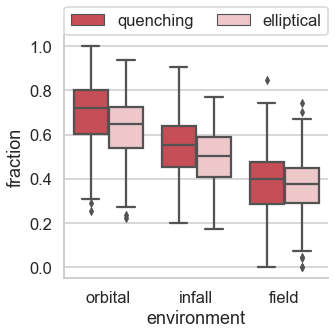

In [72]:
plot_enviroment3(cat,'quenching','elliptical',
                 title=None,outname=figure5)

In [73]:
Psp   = np.where(gal['TType'] > 0, 1, 0).astype(int)

In [74]:
# grid
xmin, xmax = 0., 3.
ymin, ymax = -13.25, -8.75
x = np.linspace(xmin, xmax, 120)  # kde resolution
y = np.linspace(ymin, ymax, 100)  # kde resolution
xx, yy = np.meshgrid(x, y)

nz = ssfr>-20
pdfR_o = get_density(rn[nz],ssfr[nz],Po[nz]*Psp[nz])
pdfR_i = get_density(rn[nz],ssfr[nz],Pi[nz]*Psp[nz])
pdfR_n = get_density(rn[nz],ssfr[nz],Pn[nz]*Psp[nz])
pdfR_f = get_density(rn[nz],ssfr[nz],Pf[nz]*Psp[nz])
pdfR_oi = get_density(rn[nz],ssfr[nz],(Pi[nz]+Po[nz])*Psp[nz])

In [78]:
def sSFRmass(image,xth=0.0,ax=None,title=None,xlabel=label_log_smass):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

#     cfset = ax.contourf(xx, yy, f, cmap='jet')
    #ax.imshow(np.rot90(image), cmap='jet', extent=[xmin, xmax, ymin, ymax], aspect=0.5)
    im = ax.scatter(xx.flatten(),yy.flatten(), s=100,c=image.T.flatten(),cmap='jet')
    cset = ax.contour(xx, yy, image.T, 4, colors='k')
    ax.clabel(cset, inline=1, fontsize=10, inline_spacing=0)
    ax.set_xlabel(xlabel)
    ax.axhline(-11.0,ls='--',lw=3,color='white')
    if title is not None:
        ax.set_title(title,fontsize=24)

<ipython-input-4-5be156659e0a>:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if is_tight: fig.tight_layout()


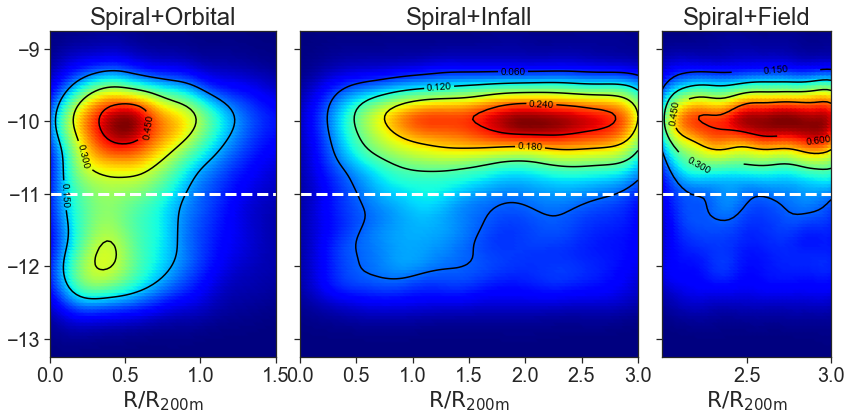

In [81]:
sns.set_style("ticks")
sns.set_context('notebook',font_scale=1.8)

# fig, axis = plt.subplots(1, 3, figsize=(3*6,6.2), sharey='row')
fig = plt.figure(figsize=(14,6.))
# Add a gridspec with two rows and one columns and a ratio of 2.5 to 7 between
gs = fig.add_gridspec(1, 3,  width_ratios=(2., 3, 1.5),
                      wspace=0.1, hspace=0.1)

# defining sub-axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1],sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

sSFRmass(pdfR_o,ax=ax1,title='Spiral+'+list_labels_dynamics[0],xlabel=label_rnorm)
sSFRmass(pdfR_i,ax=ax2,title='Spiral+'+list_labels_dynamics[1],xlabel=label_rnorm)
sSFRmass(pdfR_f,ax=ax3,title='Spiral+'+list_labels_dynamics[3],xlabel=label_rnorm)
ax1.set_xlim(0,1.5)
ax3.set_xlim(2.,3.)

ax1.set_xticks(np.arange(0.,1.5+0.5,0.5))
ax2.set_xticks(np.arange(0.,3+0.5,0.5))
ax3.set_xticks(np.array([2.5,3.]))
axis[0].set_ylabel(label_ssfr)
save_figures(fig,figure6,is_tight=True)

## Illustris TNG300